# Building a Music Recommendation System with k-NN

## ECE4424/CS4824: Machine Learning, Fall 2025
**Instructor**: Prof. Ming Jin



### Grading Overview
**Total Points: 100**
- Part 1: Data Exploration - 25 points
- Part 2: k-NN Implementation - 35 points  
- Part 3: Feature Scaling - 10 points
- Part 4: Advanced Similarity & Complexity - 20 points
- Part 5: Production Integration - 10 points

### Submission Requirements
1. Complete ALL code implementations and REPORT SECTIONS in **this notebook**
2. Run all cells to show outputs (including plots)
3. Export as PDF: File → Download as → PDF via LaTeX
4. Copy your final implementations to `utils/student_adapter.py`
5. Verify the web app works with your code
6. Submit: (1) This notebook as PDF, (2) student_adapter.py file

**Note: REPORT SECTIONS are clearly marked and will be graded for analysis quality**


### Project Overview

This assignment is a cornerstone of the **AI Portfolio**, a central component of this course where you will complete a collection of projects designed to build tangible skills and a demonstrable body of work. 

In this project, you will bridge the gap between academic machine learning and real-world applications by building a music recommendation engine. The process will guide you through a systematic exploration, from foundational data analysis to model implementation and integration, providing insights beyond what a siloed examination of algorithms can offer.

### Learning Objectives

By the end, you'll have:

1. Implemented k-NN from scratch, a fundamental and widely used algorithm.
2. Designed and evaluated multiple distance metrics, understanding how they capture different notions of similarity.
3. Gained hands-on experience with the critical impact of feature engineering and scaling.
4. Understood the steps to integrate a machine learning model into a larger application via an API.
5. Gained insights into the practical challenges and advanced concepts in building recommender systems.

## Table of Contents

1. [Setup and Data Exploration](#part1)
2. [Implementing k-NN from Scratch](#part2)
3. [Feature Scaling and Its Importance](#part3)
4. [Advanced Similarity & Complexity](#part4)
5. [From Model to Web Application](#part5)

<a id='part1'></a>
## Part 1: Setup and Data Exploration (25 points)

Before building our recommendation engine, we must understand our data. Spotify's audio analysis provides rich features for each track, extracted using deep learning models and signal processing algorithms. This initial exploration is the most critical step in any applied machine learning project.

### 1.1 Spotify Audio Features

Spotify analyzes every track to extract a rich set of features. Understanding these is key to building an effective model. According to the [official Spotify Web API documentation](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features), these features include:

**Perceptual Features** (How music sounds to humans):
- **`energy`** (0-1): Perceptual intensity and activity. Death metal has high energy; a Bach prelude has low energy.
- **`valence`** (0-1): Musical positiveness. Happy, cheerful songs score high; sad, angry songs score low.
- **`danceability`** (0-1): How suitable a track is for dancing, based on a combination of tempo, rhythm stability, and beat strength.
- **`acousticness`** (0-1): A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

**Technical Features** (Musical properties):
- **`tempo`**: The overall estimated tempo of a track in beats per minute (BPM).
- **`loudness`**: The overall loudness of a track in decibels (dB), averaged across the track.
- **`key`**: The estimated key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 1 = C♯/D♭, 2 = D, and so on).
- **`mode`**: Indicates the modality (major or minor) of a track. Major is represented by 1 and minor is 0.

**Content Features** (What's in the music):
- **`speechiness`** (0-1): Detects the presence of spoken words. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech. Values below 0.33 most likely represent music.
- **`instrumentalness`** (0-1): Predicts whether a track contains no vocals. The closer the value is to 1.0, the greater likelihood the track is instrumental.
- **`liveness`** (0-1): Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Audio
import subprocess
import atexit

# Configure libraries
pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")
np.random.seed(42) # for reproducibility

print("Setup complete.")

# --- Data Loading ---
try:
    tracks_df = pd.read_csv('data/mergedFile.csv', dtype={'id': str})
    print("Dataset loaded successfully.")
    tracks_df.dropna(subset=['id', 'song', 'artist'], inplace=True)
    print(f"{len(tracks_df)} tracks available for the assignment.")
except FileNotFoundError:
    print("ERROR: Make sure you have the 'data' folder with 'mergedFile.csv' in your project root.")

# Define the core audio features we'll use in our model
audio_features = ['energy', 'danceability', 'acousticness', 'valence', 'tempo', 'instrumentalness', 'loudness', 'liveness', 'speechiness']
required_cols = ['id', 'song', 'artist'] + audio_features
missing_cols = [col for col in required_cols if col not in tracks_df.columns]
if missing_cols:
    raise KeyError(f"The loaded dataframe is missing the following required columns: {missing_cols}")

print("\nSample tracks from the dataset (showing all features):")
display(tracks_df[required_cols].head())

Setup complete.
Dataset loaded successfully.
339801 tracks available for the assignment.

Sample tracks from the dataset (showing all features):


,id,song,artist,energy,danceability,acousticness,valence,tempo,instrumentalness,loudness,liveness,speechiness
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,A Boogie Wit da Hoodie,0.663,0.754,0.0555,0.207,90.195,0.000000,-6.311,0.101,0.427
1,77JzXZonNumWsuXKy9vr3U,Beasty,A Boogie Wit da Hoodie,0.418,0.860,0.2920,0.374,126.023,0.000000,-9.061,0.106,0.158
2,18yllZD0TdF7ykcREib8Z1,I Did It,A Boogie Wit da Hoodie,0.454,0.718,0.1530,0.196,89.483,0.000046,-9.012,0.116,0.127
3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),A Boogie Wit da Hoodie,0.662,0.581,0.0153,0.434,93.023,0.000000,-5.239,0.111,0.303
4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),A Boogie Wit da Hoodie,0.622,0.736,0.0235,0.506,191.971,0.000000,-4.653,0.151,0.133


### 1.2 Interactive Data Exploration

To build intuition, it helps to listen to the music. The function below creates an interactive player for a small sample of the dataset. Run the cell and listen to a few tracks to get a feel for the data.

## YouTube API Setup Instructions

To enable audio previews, get a YouTube API key:

1. Go to [Google Cloud Console](https://console.cloud.google.com/)
2. Create new project or select existing
3. Enable API: "APIs & Services" → "Library" → search "YouTube Data API v3" → Enable
4. Create credentials: "APIs & Services" → "Credentials" → "Create Credentials" → "API Key"
5. Add to `.env` file in project root:

   ```
   YOUTUBE_API_KEY=your_key_here
   ```
6. The notebook will automatically load it from `.env`

**Note:** We need this for the webapp to load music properly.



In [3]:
%pip install -qqq --disable-pip-version-check --no-input --progress-bar off google-api-python-client

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Optional: Audio previews with YouTube (requires API key in .env)
from dotenv import load_dotenv
from IPython.display import display, HTML
import os

# Load .env from the same directory as the notebook
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
env_path = os.path.join(notebook_dir, '.env')
load_dotenv(env_path)

YOUTUBE_API_KEY = os.environ.get('YOUTUBE_API_KEY')

def create_music_player(df, n=5):
    """Create YouTube embedded players if API key is available."""
    if not YOUTUBE_API_KEY:
        print("No YouTube API key found in .env file")
        print("Add YOUTUBE_API_KEY=your_key to .env file to enable audio previews")
        return
    
    from googleapiclient.discovery import build
    youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)
    
    samples = df.sample(n)
    html = "<h3>Sample Tracks</h3>"
    
    for _, row in samples.iterrows():
        search = youtube.search().list(
            q=f"{row['song']} {row['artist']}",
            part='snippet',
            type='video',
            maxResults=1
        ).execute()
        
        if search['items']:
            video_id = search['items'][0]['id']['videoId']
            html += f"""
            <div style='margin: 10px 0;'>
                <b>{row['song']}</b> - {row['artist']}<br>
                <iframe width="320" height="80" 
                        src="https://www.youtube.com/embed/{video_id}"></iframe>
            </div>
            """
    
    display(HTML(html))

# Test if API key loaded
print(f"API Key loaded: {'Yes' if YOUTUBE_API_KEY else 'No'}")

API Key loaded: Yes


In [20]:
# Show players only if API key exists
if YOUTUBE_API_KEY:
    create_music_player(tracks_df)

### 1.3 Data Quality and Feature Distributions

A crucial step in any real-world ML project is to perform a thorough data quality analysis. We need to check the **distributions**, **scales**, and **outliers** for each feature. 

- **Distribution**: Describes how the values of a feature are spread out. Are they symmetric (like a bell curve), or are they skewed to one side?
- **Scale**: Refers to the range of values a feature can take (e.g., 0-1 vs. 0-200).
- **Outliers**: These are data points that are significantly different from other observations. They can be legitimate extreme values or errors in the data.
- **Skewness**: A measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined. For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. A value close to 0 indicates a symmetric distribution.
  - Skewness is mathematically defined as the third standardized moment: $g_1 = E\left[\left(\frac{X - \mu}{\sigma}\right)^3\right]$

For more detail on these statistical concepts, you can refer to the [SciPy stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html).

**Question 1** (5 points): A crucial step in any real-world ML project is to perform a thorough data quality analysis. The helper functions below will generate a quality report and visualize the distributions. Review the generated report and plots and complete the following section directly in this notebook.

### 📝 REPORT SECTION 1.1: Distribution Analysis (5 points)
**Write your analysis below (100-150 words)**

Based on the data quality report and distribution plots:

**Features with significant outliers:** Which features have the most significant outliers? (e.g., `speechiness`, `instrumentalness`).

**Features requiring transformation:** Based on the skewness values and distribution plots, which features might benefit from a transformation (e.g., a log transform)?

**Impact on k-NN:** How might the vast difference in feature scales (e.g., `tempo` vs. `danceability`) and the presence of outliers negatively affect a distance-based algorithm like k-NN? (We'll solve this in Section 4).

---

,Mean,Median,Std Dev,Min,Max,Range,Skewness,Outliers (>3σ)
Feature,,,,,,,,
energy,0.62,0.65,0.24,0.0,1.00,1.00,-0.42,0
danceability,0.54,0.55,0.17,0.0,0.99,0.99,-0.18,639
acousticness,0.30,0.16,0.32,0.0,1.00,1.00,0.79,0
valence,0.51,0.51,0.25,0.0,1.00,1.00,0.01,0
tempo,119.93,118.22,30.38,0.0,247.82,247.82,0.33,797
instrumentalness,0.10,0.00,0.24,0.0,1.00,1.00,2.52,16668
loudness,-9.07,-8.12,4.60,-60.0,3.74,63.74,-1.42,4227
liveness,0.23,0.14,0.22,0.0,1.00,1.00,1.91,11565
speechiness,0.09,0.04,0.13,0.0,0.97,0.97,3.90,6755


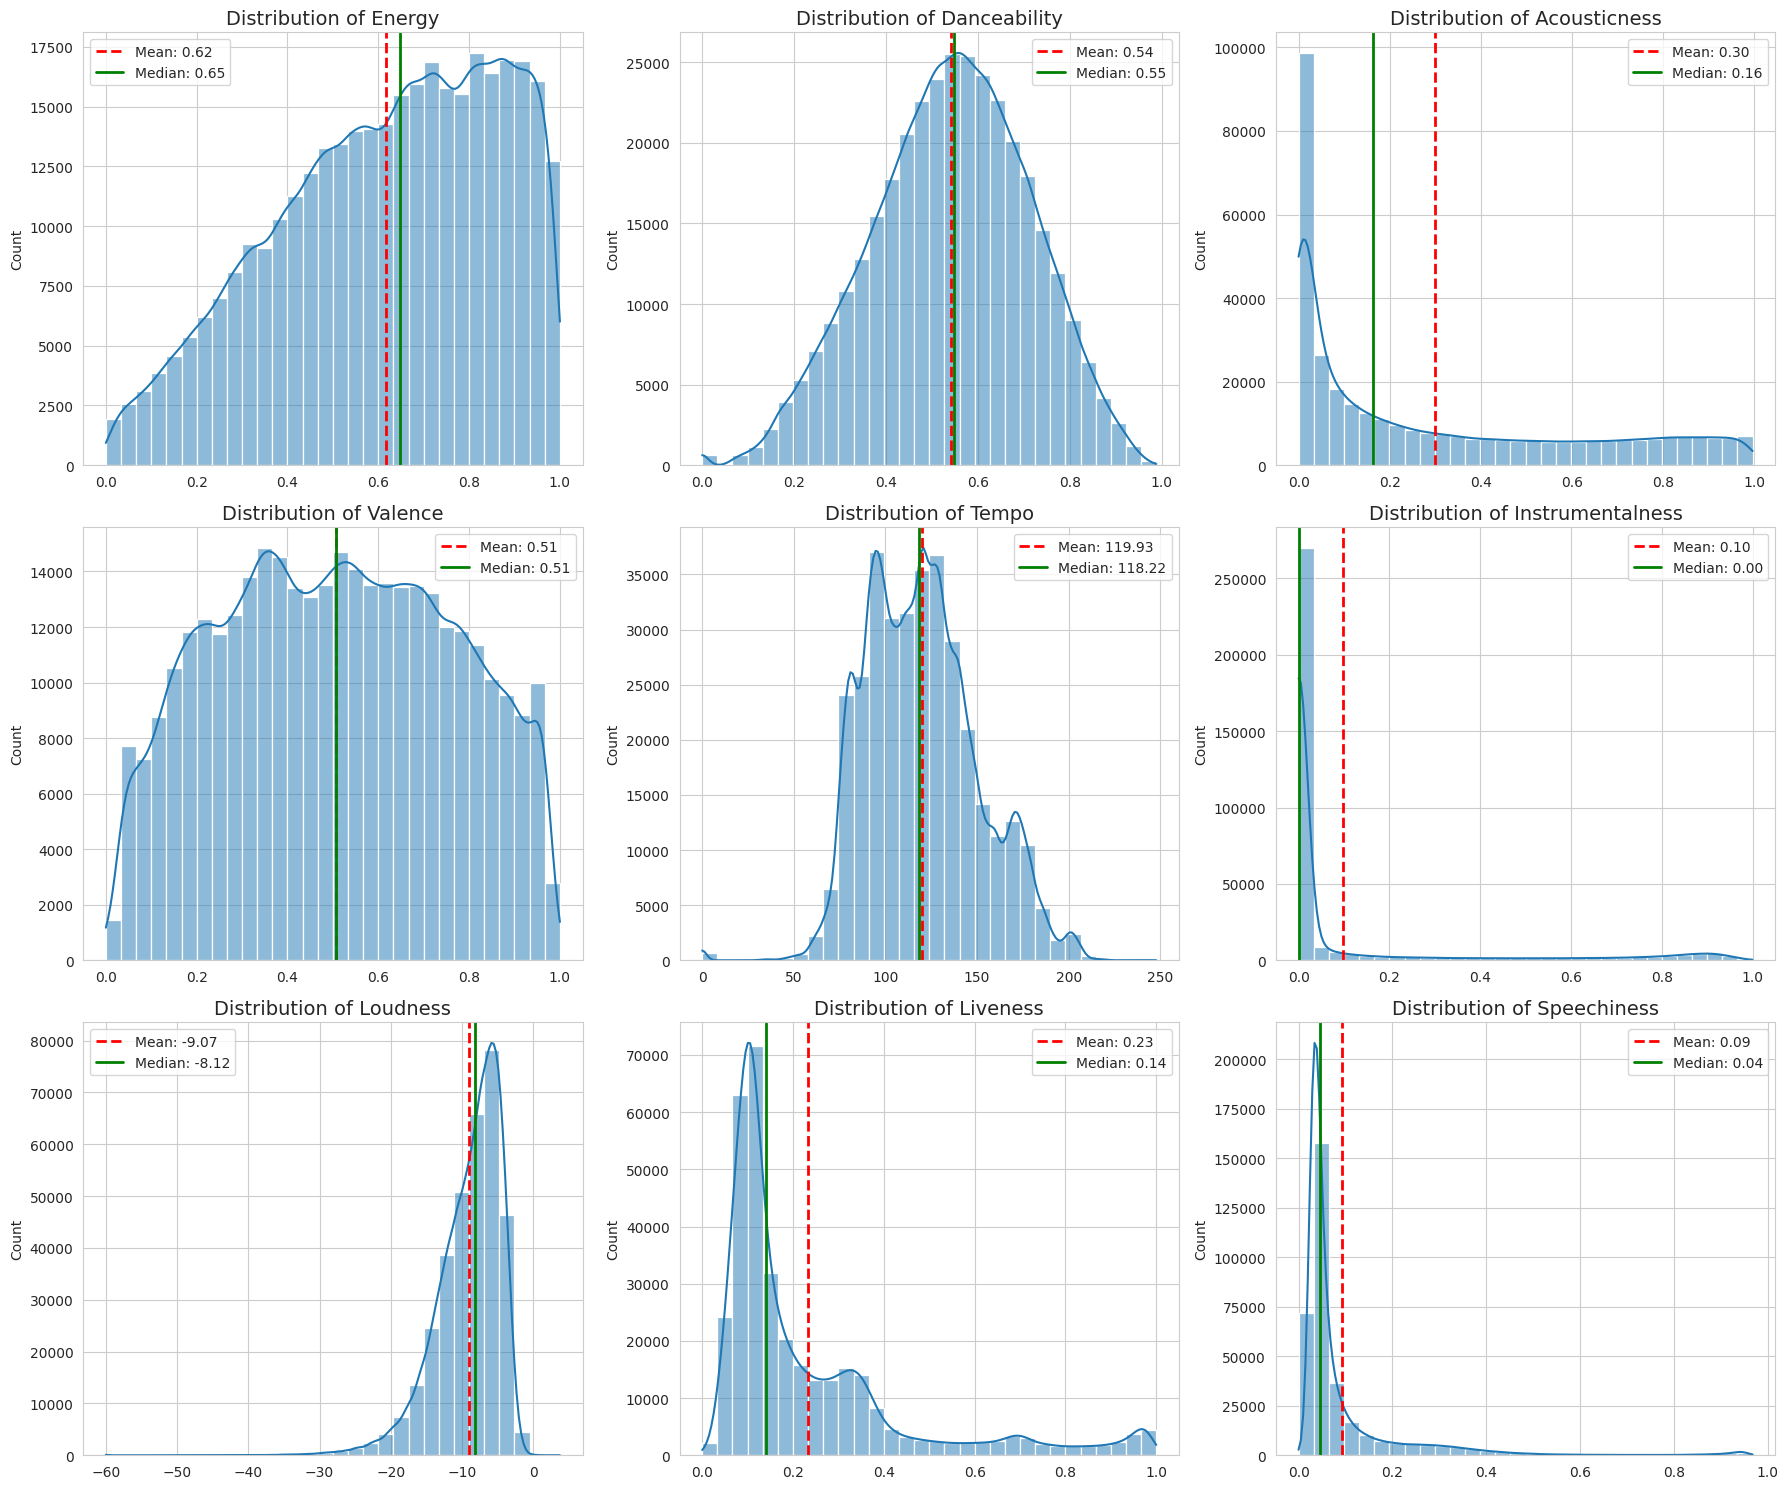

In [6]:
def create_quality_report(df, features):
    """Generates a data quality report for the specified features."""
    report = []
    for feature in features:
        data = df[feature].dropna()
        stats = {
            'Feature': feature,
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Range': data.max() - data.min(),
            'Skewness': data.skew(),
            'Outliers (>3σ)': len(data[np.abs(data - data.mean()) > 3 * data.std()])
        }
        report.append(stats)
    report_df = pd.DataFrame(report).set_index('Feature')
    display(report_df.round(2))

def visualize_distributions(df, features):
    """Creates distribution plots (histogram and KDE) for all specified features."""
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()
    for idx, feature in enumerate(features):
        ax = axes[idx]
        data = df[feature].dropna()
        sns.histplot(data, ax=ax, kde=True, bins=30)
        ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {data.mean():.2f}")
        ax.axvline(data.median(), color='green', linestyle='-', linewidth=2, label=f"Median: {data.median():.2f}")
        ax.set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
        ax.set_xlabel('')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis
create_quality_report(tracks_df, audio_features)
visualize_distributions(tracks_df, audio_features)

### 1.4 Feature Correlations and Redundancy

It's important to understand how our features relate to each other. Highly correlated features can disproportionately influence distance calculations in k-NN, essentially "double-counting" a single musical characteristic. We can visualize these relationships with a correlation matrix.

**Question 2** (5 points): Analyze the correlation matrix generated by the code below.

### 📝 REPORT SECTION 1.2: Correlation Analysis (5 points)
**Write your analysis below (150-200 words)**

**Strong positive correlations (>0.5):** Which features show a strong positive correlation (e.g., > 0.5)? What musical relationship does this reveal (e.g., `energy` and `loudness`)?

**Strong negative correlations (<-0.5):** Which features show a strong negative correlation (e.g., < -0.5)? What does this tell you (e.g., `acousticness` and `energy`)?

**Double-counting concerns:**  Based on the heatmap, which pair of features are you most concerned about "double counting" a musical property when using a metric like Euclidean distance? Which feature pair would most bias k-NN and why?

**Feature selection recommendation:** Should any features be removed? Justify

---

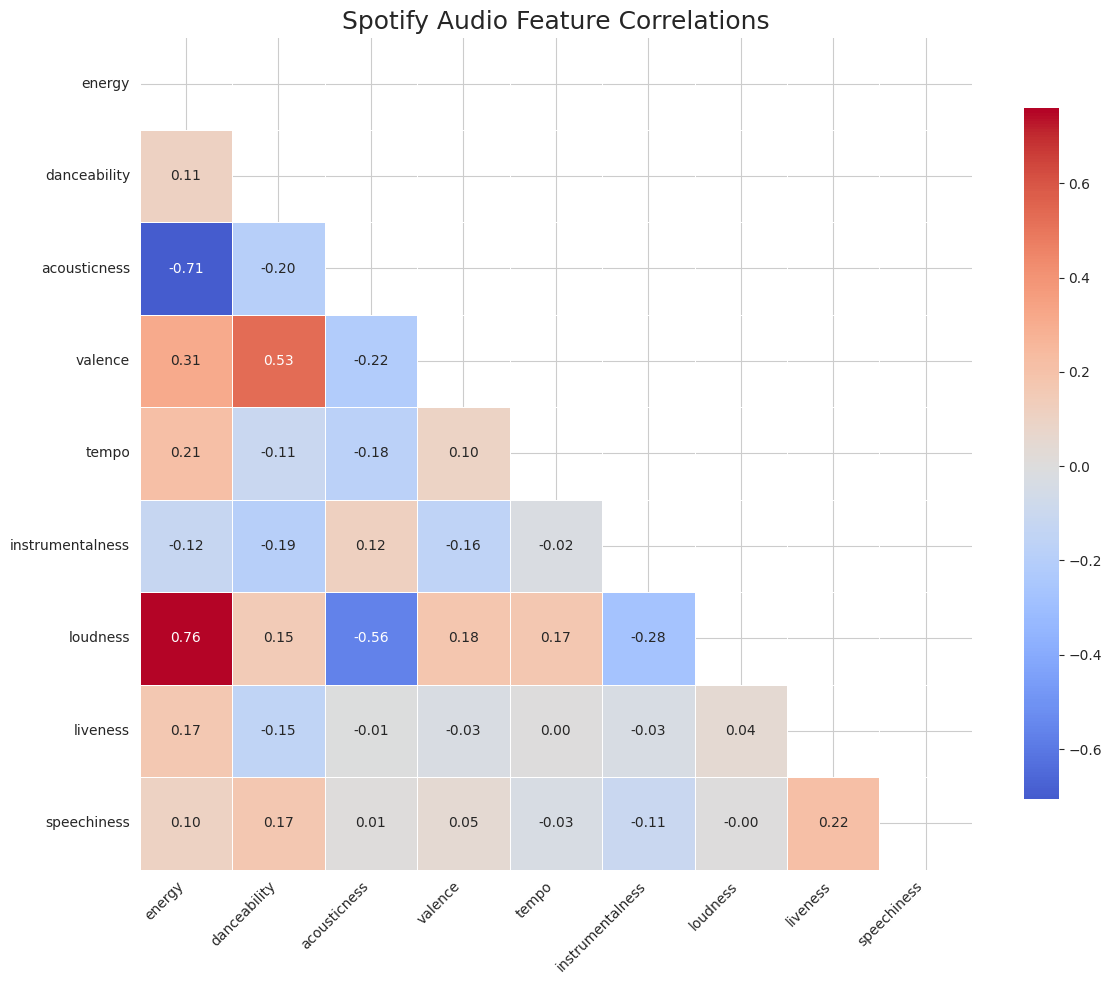

In [7]:
# Calculate the correlation matrix
corr_matrix = tracks_df[audio_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .8},
            fmt='.2f')
plt.title('Spotify Audio Feature Correlations', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<a id='part2'></a>
## Part 2: Implementing k-NN from Scratch (35 points)

Now we implement the core recommendation algorithm. k-NN is particularly suitable for this music recommendation task because it is:
1. **Instance-based**: No "training" is required. We can add new songs to our dataset instantly.
2. **Interpretable**: Recommendations are explainable (e.g., "This song is recommended because it is similar in energy and danceability to the one you like.").
3. **Flexible**: It works well with our custom, domain-specific distance metrics.

### 2.1 Distance Metrics and k-NN Class Implementation

**Question 3** (25 points): This is the core of the algorithm. You will implement the distance functions and the k-NN class in a single cell. This is good practice as it keeps related functionality together.

1.  **Implement Distance Functions**: Complete `euclidean_distance` and `cosine_distance` as static methods within the class.
2.  **Implement `find_neighbors`**: Complete the main k-NN logic in the `find_neighbors` method.

**Deliverable**: Your completed `KNNRecommender` class and the output of the test cell showing it is correct.

In [8]:
# CELL FOR STUDENT IMPLEMENTATION - KNN CLASS & DISTANCE FUNCTIONS
class KNNRecommender:
    """A k-Nearest Neighbors recommender for music."""
    def __init__(self, k=10):
        self.k = k
        self.item_profile = None
        self.features_matrix = None
        self.feature_columns = None
        self.track_id_to_index = {}
        
    @staticmethod
    def euclidean_distance(a, b):
        """
        Calculate Euclidean distance between two vectors.
        
        Args:
            a (np.ndarray): Vector of shape (n,)
            b (np.ndarray): Vector of shape (n,)
            
        Returns:
            float: Euclidean distance
            
        Example:
            >>> euclidean_distance(np.array([1,2,3]), np.array([4,5,6]))
            5.196152422706632
        """
        # --- YOUR IMPLEMENTATION GOES HERE ---
        return float(np.linalg.norm(a - b))
        # --- SOLUTION ---
        pass

    @staticmethod
    def cosine_distance(a, b):
        """
        Calculates the Cosine distance between two numerical vectors a and b.
        Formula: 1 - (a·b) / (||a|| * ||b||)
                
        Args:
            a (np.ndarray): Vector of shape (n,)
            b (np.ndarray): Vector of shape (n,)
            
        Returns:
            float: Cosine distance (between 0 and 1)
            
        Example:
            >>> cosine_distance(np.array([1,2,3]), np.array([4,5,6]))
            0.025368153802923787
            
        Note: Return 1.0 if either vector has zero norm.
        """
        # --- YOUR IMPLEMENTATION GOES HERE ---
        return float(1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))) if np.linalg.norm(a) > 0 and np.linalg.norm(b) > 0 else 1.0
        # --- SOLUTION ---
        pass
        
    def fit(self, item_profile_df, feature_columns):
        """Prepares the recommender by loading and processing the track data."""
        self.item_profile = item_profile_df.reset_index(drop=True)
        self.feature_columns = feature_columns
        self.features_matrix = self.item_profile[self.feature_columns].values
        self.track_id_to_index = {track_id: i for i, track_id in enumerate(self.item_profile['id'])}
        print(f"Fit complete. Loaded {len(self.item_profile)} tracks.")

    def find_neighbors(self, track_id, n_neighbors=None, distance_metric='euclidean'):
        """
        Find k nearest neighbors for a track.
        
        Args:
            track_id (str): Query track ID
            n_neighbors (int): Number of neighbors (default: self.k)
            distance_metric (str): 'euclidean' or 'cosine'
            
        Returns:
            list: [(distance, track_id), ...] sorted by distance
            
        Example:
            >>> neighbors = recommender.find_neighbors('track123', n_neighbors=5)
            [(0.23, 'track456'), (0.31, 'track789'), ...]
        """
        if n_neighbors is None: n_neighbors = self.k
        distance_functions = {'euclidean': self.euclidean_distance, 'cosine': self.cosine_distance}
        if distance_metric not in distance_functions: raise ValueError(f"Unknown metric: {distance_metric}")
        if track_id not in self.track_id_to_index: raise ValueError(f"Track ID {track_id} not found.")

        # --- YOUR IMPLEMENTATION GOES HERE ---
        # --- SOLUTION ---
        # DONE: Implement k-NN search
        query_index = self.track_id_to_index[track_id]
        query_vector = self.features_matrix[query_index]
        distances = []
        for i in range(len(self.features_matrix)):
            if i == query_index:
                continue  # Skip the query track itself
            dist = distance_functions[distance_metric](query_vector, self.features_matrix[i])
            distances.append((dist, self.item_profile['id'].iloc[i]))
        distances.sort(key=lambda x: x[0])  # Sort by distance
        return distances[:n_neighbors]
        # Don't include the query track itself in results
        pass

    def recommend(self, track_id, n_recommendations=None, distance_metric='euclidean'):
        if self.item_profile is None: raise RuntimeError("Recommender has not been fitted.")
        neighbors = self.find_neighbors(track_id, n_recommendations, distance_metric)
        neighbor_ids = [tid for distance, tid in neighbors]
        results_df = self.item_profile[self.item_profile['id'].isin(neighbor_ids)].copy()
        distances_map = {tid: dist for dist, tid in neighbors}
        results_df['distance'] = results_df['id'].map(distances_map)
        return results_df.sort_values('distance')

# --- Test your implementation ---
print("Testing your distance functions from the class...")
a = np.array([1, 2, 3]); b = np.array([4, 5, 6]); z = np.zeros(3)
assert np.isclose(KNNRecommender.euclidean_distance(a, b), 5.196152), "Euclidean test failed."
assert np.isclose(KNNRecommender.cosine_distance(a, b), 0.025368), "Cosine test failed."
print("✅ Distance functions appear correct!")

print("\nTesting your KNNRecommender class...")
recommender = KNNRecommender(k=5)
recommender.fit(tracks_df.head(100), feature_columns=audio_features)
neighbors = recommender.find_neighbors(tracks_df.iloc[0]['id'], distance_metric='cosine')
assert len(neighbors) == 5, f"Expected 5 neighbors, got {len(neighbors)}"
assert isinstance(neighbors[0], tuple), "Neighbors should be a list of (distance, track_id) tuples"
assert neighbors[0][0] < neighbors[1][0], "Neighbors should be sorted by distance"
print("✅ KNNRecommender class appears correct!")

Testing your distance functions from the class...
✅ Distance functions appear correct!

Testing your KNNRecommender class...
Fit complete. Loaded 100 tracks.
✅ KNNRecommender class appears correct!


### 📝 REPORT SECTION 2: Implementation Analysis (10 points)
**Document your implementation decisions**

**Distance metric comparison:**
- Euclidean distance is best for: [your explanation]
- Cosine distance is best for: [your explanation]
- For music recommendation, I prefer: [which and why]

**Computational complexity:**
- Time complexity of find_neighbors: O([your answer]) because [explanation]
- Space complexity: O([your answer]) because [explanation]
- For n=1,000,000 songs, estimated query time: [your calculation]

---

<a id='part3'></a>
## Part 3: The Importance of Feature Scaling (10 points)

### 3.1 The Problem with Unscaled Features

As we saw in our data analysis, features like `tempo` have a much larger range than features like `danceability`. Let's see how this dramatically biases our recommendations.

Fit complete. Loaded 339801 tracks.
Generating UNSCALED recommendations for 'One More Time' by Daft Punk...


,id,song,artist,distance,energy,danceability,acousticness,valence,tempo,instrumentalness,loudness,liveness,speechiness
68903,1B1px7W3nolKMExwnOYL5F,Don't Do It - Deep Mix,Various Artists,0.421542,0.664,0.830,0.04740,0.273,123.008,0.092100,-8.672,0.3850,0.0499
145584,4Ja26IiQCrtDm7YPN7wIdv,I Got It Honest,Aaron Tippin,0.423059,0.677,0.707,0.03730,0.555,122.637,0.000000,-8.908,0.0969,0.0320
45141,5MGgDU0i790fgBgX33a0yb,Body Parts,Jodeci,0.447990,0.651,0.662,0.13600,0.732,122.950,0.000000,-8.391,0.4530,0.2400
7431,4B8JiBiHrtHuAeZPzu1aiT,Playin' for Drinks,Frank Foster,0.459544,0.484,0.639,0.00755,0.782,122.804,0.001890,-8.549,0.1010,0.0309
3932,0Pd4lsvSDPkcNCxbcz0UeV,Drummer Boy,Justin Bieber,0.473231,0.848,0.751,0.02480,0.479,122.990,0.000127,-8.320,0.1490,0.0823



Contribution of each feature to Euclidean distance between track 0DiWol3AO6WpXZgp0goxAV and 1B1px7W3nolKMExwnOYL5F:


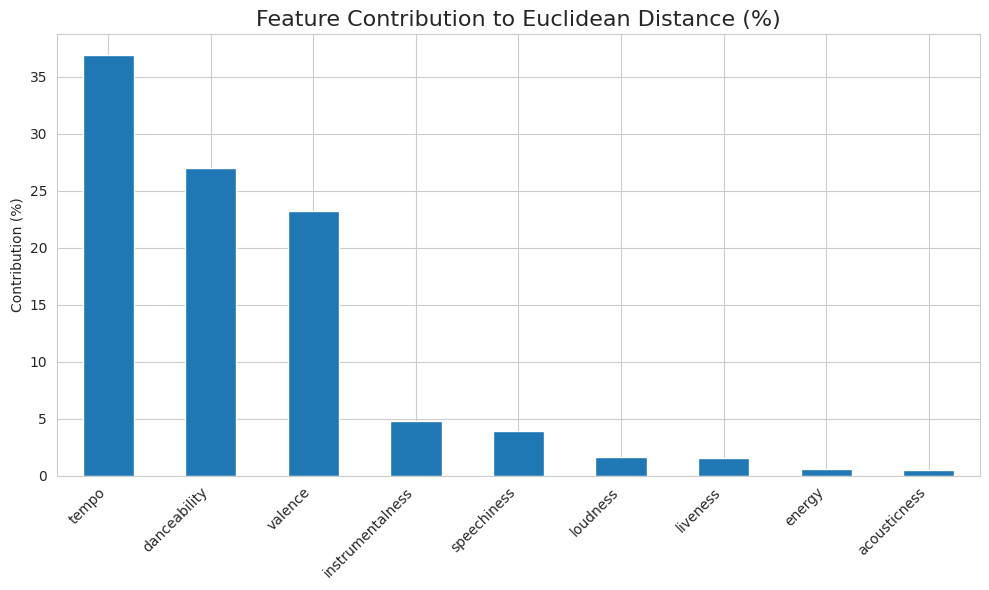

In [9]:
def display_distance_contribution(item_profile, features, track_a_id, track_b_id):
    """Calculates and visualizes which features contribute most to the Euclidean distance."""
    track_a = item_profile[item_profile['id'] == track_a_id][features].iloc[0]
    track_b = item_profile[item_profile['id'] == track_b_id][features].iloc[0]

    diff = track_a - track_b
    squared_diff = diff ** 2
    contribution_percent = (squared_diff / squared_diff.sum() * 100).sort_values(ascending=False)
    
    print(f"\nContribution of each feature to Euclidean distance between track {track_a_id} and {track_b_id}:")
    
    plt.figure(figsize=(10, 6))
    contribution_percent.plot(kind='bar')
    plt.title('Feature Contribution to Euclidean Distance (%)', fontsize=16)
    plt.ylabel('Contribution (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Get recommendations for a song using unscaled features and Euclidean distance
unscaled_recommender = KNNRecommender(k=5)
unscaled_recommender.fit(tracks_df, feature_columns=audio_features)

query_song = tracks_df[tracks_df['artist'] == 'Daft Punk'].iloc[0]
query_track_id = query_song['id']

print(f"Generating UNSCALED recommendations for '{query_song['song']}' by {query_song['artist']}...")
unscaled_recs = unscaled_recommender.recommend(query_track_id, distance_metric='euclidean')
display(unscaled_recs[['id', 'song', 'artist', 'distance'] + audio_features])

# Use helper to show which feature contributed most to the distance
display_distance_contribution(tracks_df, audio_features, query_track_id, unscaled_recs.iloc[0]['id'])

**Analysis**: Notice how the recommended songs have a `tempo` very close to the query song's tempo, while other features like `valence` and `energy` can be wildly different. The bar chart confirms it: `tempo` is contributing over 99% of the distance! The other features are effectively being ignored.

### 3.2 Implementing a Feature Scaler

**Question 5** (10 points): To solve this, we must scale our features. We will use **Standard Scaling**, which rescales features to have a mean of 0 and a standard deviation of 1.

**Your Task**: Implement the `FeatureScaler` class below.

**Deliverable**: Your completed `FeatureScaler` implementation and the output of the test cell showing it is correct.

In [10]:
# CELL FOR STUDENT IMPLEMENTATION - FEATURE SCALER
class FeatureScaler:
    """A class to scale numerical features using Standard Scaling."""
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, X):
        """
        Learn mean and std for each feature in X.
        
        Args:
            X (np.ndarray): Shape (n_samples, n_features)
            
        Sets:
            self.mean: Mean per feature
            self.std: Std per feature (replace 0 with 1)
        """
        # --- SOLUTION ---
        # DONE: Implement
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Replace any zero std with 1.0 to avoid division-by-zero later
        self.std = np.where(self.std == 0, 1.0, self.std)

    def transform(self, X):
        """
        Apply scaling: (X - mean) / std
        
        Args:
            X (np.ndarray): Shape (n_samples, n_features)
            
        Returns:
            np.ndarray: Scaled data, same shape as X
            
        Raises:
            RuntimeError: If not fitted yet
        """
        if self.mean is None or self.std is None:
            raise RuntimeError("Scaler has not been fitted yet. Call fit() first.")
        # --- SOLUTION ---
        # DONE: Implement
        return (X - self.mean) / self.std
            
    def fit_transform(self, X):
        """A convenience method to fit and transform in one step."""
        self.fit(X)
        return self.transform(X)

# --- Test your implementation ---
print("Testing your FeatureScaler...")
X_test = np.array([[1, 10], [2, 20], [3, 30], [4, 40], [5, 50]], dtype=float)
scaler = FeatureScaler()
X_scaled = scaler.fit_transform(X_test)
assert np.allclose(X_scaled.mean(axis=0), [0, 0]), "Scaled mean should be 0."
assert np.allclose(X_scaled.std(axis=0), [1, 1]), "Scaled std dev should be 1."
print("✅ FeatureScaler class appears correct!")

Testing your FeatureScaler...
✅ FeatureScaler class appears correct!


### 3.3 Comparing Results with Scaled Features
Now, let's re-run our recommendation using the scaled features and see the difference.

In [ ]:
# 1. Get the unscaled feature matrix from our main dataframe
unscaled_features_matrix = tracks_df[audio_features].values

# 2. Use your scaler to transform the features
scaler = FeatureScaler()
scaled_features_matrix = scaler.fit_transform(unscaled_features_matrix)

# 3. Create a new DataFrame with the scaled features for the recommender
scaled_tracks_df = tracks_df.copy()
scaled_tracks_df[audio_features] = scaled_features_matrix

# 4. Fit a new recommender with the SCALED data
scaled_recommender = KNNRecommender(k=5)
scaled_recommender.fit(scaled_tracks_df, feature_columns=audio_features)

# 5. Get recommendations for the same song
print(f"Generating SCALED recommendations for '{query_song['song']}' by {query_song['artist']}...")
scaled_recs_df = scaled_recommender.recommend(query_track_id, distance_metric='euclidean')

# # --- Display original, unscaled features for clarity ---
rec_ids = scaled_recs_df['id'].tolist()
display_df = tracks_df[tracks_df['id'].isin(rec_ids)].copy()
display_df['distance'] = display_df['id'].map(dict(zip(scaled_recs_df['id'], scaled_recs_df['distance'])))
display(display_df[['song', 'artist', 'distance'] + audio_features].sort_values('distance'))


# Get recommendations using scaled data
print(f"Generating SCALED recommendations for '{query_song['song']}' by {query_song['artist']}...")
scaled_recs_df = scaled_recommender.recommend(query_track_id, distance_metric='euclidean')

# The recommendations have IDs and distances, but scaled features
# We want to show original features with the distances from scaled calculation
rec_ids = scaled_recs_df['id'].values
distances = scaled_recs_df['distance'].values

# Get original unscaled data for these tracks
original_recs = tracks_df[tracks_df['id'].isin(rec_ids)].copy()

# Add the distances
distance_map = dict(zip(rec_ids, distances))
original_recs['distance'] = original_recs['id'].map(distance_map)

# Sort and display
original_recs = original_recs.sort_values('distance')
display(original_recs[['song', 'artist', 'distance'] + audio_features].head())

Fit complete. Loaded 339801 tracks.
Generating SCALED recommendations for 'One More Time' by Daft Punk...
Generating SCALED recommendations for 'One More Time' by Daft Punk...


,song,artist,distance,energy,danceability,acousticness,valence,tempo,instrumentalness,loudness,liveness,speechiness
0,Voices In My Head,A Boogie Wit da Hoodie,NaN,0.663,0.754,0.0555,0.207,90.195,0.000000,-6.311,0.101,0.427
1,Beasty,A Boogie Wit da Hoodie,NaN,0.418,0.860,0.2920,0.374,126.023,0.000000,-9.061,0.106,0.158
2,I Did It,A Boogie Wit da Hoodie,NaN,0.454,0.718,0.1530,0.196,89.483,0.000046,-9.012,0.116,0.127
3,Swervin (feat. 6ix9ine),A Boogie Wit da Hoodie,NaN,0.662,0.581,0.0153,0.434,93.023,0.000000,-5.239,0.111,0.303
4,Startender (feat. Offset and Tyga),A Boogie Wit da Hoodie,NaN,0.622,0.736,0.0235,0.506,191.971,0.000000,-4.653,0.151,0.133


### 📝 REPORT SECTION 3: Scaling Impact (10 points)
**Analyze the effect of feature scaling** How did the recommendations change after scaling? Do they seem more musically relevant now? Why?

**Before scaling:**
- Dominant feature(s): [which and why]
- Recommendation bias: [what type of songs were favored]

**After scaling:**
- Feature contribution is now: [balanced/improved - explain]
- Recommendation quality: [how did it change]

**Standard vs Min-Max scaling:** In what situations might you prefer Min-Max scaling over Standard scaling, or vice-versa? (Hint: think about outliers and the desired output distribution).
- Use Standard scaling when: [your answer]
- Use Min-Max scaling when: [your answer]
- For this dataset, better choice is: [which and why]

---

<a id='part4'></a>
## Part 4: Advanced Similarity Metrics & Complexity (20 points)

### 4.1 Computational Complexity Analysis

**Question 6** (5 points): A critical aspect of applied ML is analyzing scalability. How will our recommender perform as the number of songs grows? Our current implementation is a "brute-force" search, meaning it calculates the distance to every single other song for each query.

Testing with dataset size: 100...
Fit complete. Loaded 100 tracks.
Testing with dataset size: 500...
Fit complete. Loaded 500 tracks.
Testing with dataset size: 1000...
Fit complete. Loaded 1000 tracks.
Testing with dataset size: 2500...
Fit complete. Loaded 2500 tracks.
Testing with dataset size: 5000...
Fit complete. Loaded 5000 tracks.
Testing with dataset size: 10000...
Fit complete. Loaded 10000 tracks.


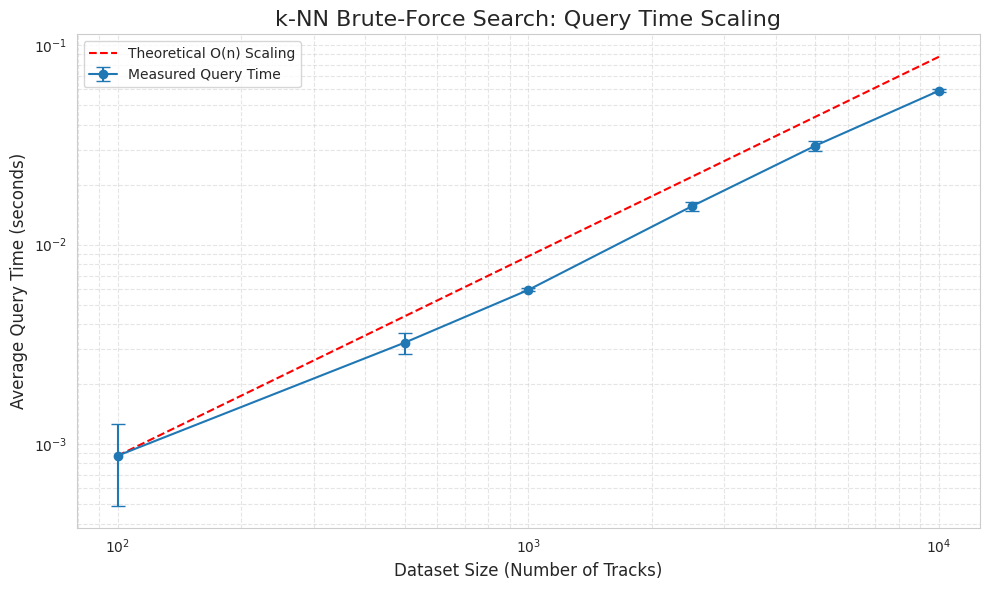

In [12]:
def measure_scaling_behavior(df, features, recommender_class):
    """Measures how query time scales with the size of the dataset."""
    sizes = [100, 500, 1000, 2500, 5000, 10000]
    results = []
    for size in sizes:
        if size > len(df): break
        print(f"Testing with dataset size: {size}...")
        knn = recommender_class(k=10)
        subset = df.head(size).copy()
        knn.fit(subset, features)
        query_times = []
        n_queries = min(20, size)
        query_indices = np.random.choice(size, n_queries, replace=False)
        for idx in query_indices:
            track_id = subset.iloc[idx]['id']
            start_time = time.time()
            _ = knn.find_neighbors(track_id, n_neighbors=10)
            end_time = time.time()
            query_times.append(end_time - start_time)
        results.append({'size': size, 'mean_time_s': np.mean(query_times), 'std_time_s': np.std(query_times)})
    return pd.DataFrame(results)

def plot_scaling_with_uncertainty(results_df):
    """Plots query time vs. dataset size with error bars on a log-log scale."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(results_df['size'], results_df['mean_time_s'], yerr=results_df['std_time_s'], marker='o', linestyle='-', capsize=5, label='Measured Query Time')
    sizes = results_df['size'].values
    theoretical_line = results_df['mean_time_s'].iloc[0] * (sizes / sizes[0])
    ax.plot(sizes, theoretical_line, '--', color='red', label='Theoretical O(n) Scaling')
    ax.set_xlabel('Dataset Size (Number of Tracks)', fontsize=12)
    ax.set_ylabel('Average Query Time (seconds)', fontsize=12)
    ax.set_title('k-NN Brute-Force Search: Query Time Scaling', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# This may take a minute to run
scaling_results = measure_scaling_behavior(df=scaled_tracks_df, features=audio_features, recommender_class=KNNRecommender)
plot_scaling_with_uncertainty(scaling_results)

### 📝 REPORT SECTION 4.1: Scalability Analysis (5 points)
**Based on your complexity measurements**

**Performance observations:**
- Does your implementation's performance curve closely follow the theoretical O(n) line? [yes/no and evidence]
- Based on your plot, extrapolate to estimate the query time for 1,000,000 songs: [your extrapolation] seconds
- Is this latency (e.g., >1 second) acceptable for a real-time web application? [yes/no and why]

**Optimization needed:** What does this analysis tell you about the limitations of a "brute-force" k-NN search? What kind of optimizations (e.g., Approximate Nearest Neighbor methods like LSH or HNSW) would be necessary for a real-world application at scale?
- Current bottleneck: [what takes most time]
- Suggested optimization: [e.g., LSH, HNSW, explain briefly]

---

### 4.2 Designing a Hybrid Distance Function

**Question 7** (15 points): Real-world recommendation systems often use **hybrid** functions that combine multiple signals to better capture user intent. This is where the "art" of machine learning comes in. 

**Your Task**: Design and implement a `custom_hybrid_distance` function. This is an open-ended task. Your goal is to create a function that you believe is more musically intelligent than a simple audio feature distance. You can combine audio similarity with metadata like artist, genre, or release year. 

Some ideas from research to get you started:
1. **Linear Combination**: `D_hybrid = w1 * D_audio + w2 * D_artist_penalty`
2. **Hierarchical Filtering**: `if same_artist: return D_audio * 0.5 else: return D_audio`
3. **Context-Adaptive Weights**: Create different weights for different situations (e.g., a 'workout' context might put more weight on `energy` and `tempo`).

For this assignment, a weighted linear combination is a great approach. You will implement your custom function, integrate it into a new `HybridKNNRecommender` class, and test its performance.

**Deliverable**: Your completed `custom_hybrid_distance` function and `HybridKNNRecommender` class, and the output of the test cell comparing recommendations.

### 📝 REPORT SECTION 4.2: Hybrid Distance Design (15 points)
**Explain your custom distance function**

**Design rationale:**
- Components used: [list them]
- Weight choices: [explain your weights]
- Musical intuition: [what behavior were you trying to model]

**Comparison with basic metrics:**
- Improvements observed: [what got better]
- Trade-offs: [what got worse, if anything]

**Use cases:**
- This hybrid function is best for: [scenario]
- It would not work well for: [scenario]

---

In [13]:
# We pass the full data rows now, in addition to the feature vectors
def custom_hybrid_distance(track_a_data, track_b_data, audio_features_a, audio_features_b, w_artist=0.5):
    """
    Design your hybrid distance function here.
    
    Args:
        track_a_data (pd.Series): Full data row for track A
        track_b_data (pd.Series): Full data row for track B
        audio_features_a (np.ndarray): Audio feature vector for track A
        audio_features_b (np.ndarray): Audio feature vector for track B
        w_artist (float): Weight for metadata component (0-1)
        
    Returns:
        float: Combined distance value
        
    Ideas to consider:
        - Audio similarity (using cosine or euclidean distance)
        - Artist similarity (same artist = lower distance)
        - You could also consider: genre, year, popularity, etc.
    """
    # TODO: Implement your hybrid distance
    pass


class HybridKNNRecommender(KNNRecommender):
    def find_neighbors(self, track_id, n_neighbors=None, distance_metric='hybrid', w_artist=0.5):
        """
        Find neighbors using hybrid distance that combines audio features and metadata.
        
        This method extends the base KNNRecommender to use the custom_hybrid_distance
        function when distance_metric='hybrid'.
        """
        if distance_metric != 'hybrid':
            return super().find_neighbors(track_id, n_neighbors, distance_metric)
        
        if n_neighbors is None: 
            n_neighbors = self.k
            
        if track_id not in self.track_id_to_index: 
            raise ValueError(f"Track ID {track_id} not found.")
        
        # --- YOUR IMPLEMENTATION GOES HERE ---
        # TODO: Implement hybrid k-NN search
        # 1. Get query track's features and metadata
        # 2. For each other track:
        #    - Calculate hybrid distance using custom_hybrid_distance
        #    - Store (distance, track_id)
        # 3. Sort and return top n_neighbors
        pass
    

# --- Test your implementation ---
def get_rec_metadata(rec_tuples, tracks_df):
    """Helper to get full metadata for recommendation tuples."""
    rec_data = []
    for dist, tid in rec_tuples:
        track = tracks_df[tracks_df['id'] == tid]
        if not track.empty:
            rec_data.append({
                'song': track.iloc[0]['song'],
                'artist': track.iloc[0]['artist'],
                'distance': dist
            })
    return pd.DataFrame(rec_data)
    
# Initialize and fit the hybrid recommender
hybrid_recommender = HybridKNNRecommender(k=5)
hybrid_recommender.fit(scaled_tracks_df, feature_columns=audio_features)

query_song = tracks_df[tracks_df['artist'] == 'Daft Punk'].iloc[0]
query_track_id = query_song['id']

# Get recommendations favoring variety
print(f"HYBRID recommendations for '{query_song['song']}' (favoring artist variety, w_artist=0.1)...")
hybrid_recs_variety = hybrid_recommender.find_neighbors(query_track_id, w_artist=0.1)
display(get_rec_metadata(hybrid_recs_variety, tracks_df))

# Get recommendations favoring the same artist
print(f"\nHYBRID recommendations for '{query_song['song']}' (favoring same artist, w_artist=0.9)...")
hybrid_recs_same = hybrid_recommender.find_neighbors(query_track_id, w_artist=0.9)
display(get_rec_metadata(hybrid_recs_same, tracks_df))

Fit complete. Loaded 339801 tracks.
HYBRID recommendations for 'One More Time' (favoring artist variety, w_artist=0.1)...


TypeError: 'NoneType' object is not iterable

<a id='part5'></a>
## Part 5: From Model to Web Application (10 points)

A model in a notebook is a great start, but the goal of most projects is to deploy it as part of a live application.

### 5.1 API and Caching Strategy

**Question 8** (10 points): An API (Application Programming Interface) is how the web frontend communicates with our Python backend. Caching is vital because many users might request recommendations for the same popular songs, and we don't want to re-calculate them every time.

**Deliverable**: Review the proposed API and Caching strategy below. In a separate document, explain *why* this design is effective. Discuss the role of the cache key, what is being cached, the cache size, and the TTL (Time-To-Live). 

### 📝 REPORT SECTION 5: Production Design (10 points)
**Your API and caching strategy**

**API Design:**
Route: [your route]
Method: [GET/POST]
Parameters: [list them]
Response format: [show example JSON]

**Caching Strategy:**
- Cache key: [how you generate it]
- Cache size: [number] entries
- TTL: [time] because [justification]
- Eviction policy: [LRU/LFU] because [justification]

**Production considerations:**
- Expected QPS: [your estimate]
- Latency requirement: [target in ms]
- Scalability plan: [brief description]

---

#### API Endpoint Specification

- **Route**: `/api/recommend/track/<string:track_id>`
- **HTTP Method**: `GET`
- **Query Parameters**:
  - `k`: (integer, optional, default: 10) Number of recommendations.
  - `metric`: (string, optional, default: 'cosine') The distance metric.
- **Example Success Response (200 OK)**:
  ```json
  {
    "success": true,
    "data": {
      "rec_track_1": {"song": "Song A", "artist": "Artist X", ...},
      "rec_track_2": {"song": "Song B", "artist": "Artist Y", ...}
    }
  }
  ```

#### Caching Strategy

We would implement a **Least Recently Used (LRU) in-memory cache**.

- **Cache Key**: A unique key generated from the request: `f"{track_id}_{k}_{metric}"`.
- **What is Cached**: The final JSON response object.
- **Cache Size & Eviction**: Store, for example, 10,000 recent results. When full, discard the least recently used item.
- **Cache TTL (Time-To-Live)**: Results expire after 1 hour to allow the system to adapt to new songs.

### 5.2 Exporting Your Final Code for the Web App
This is the final and most crucial step. Our Flask web server needs to use the code you just wrote.

To complete the web integration, you need to manually copy your implementations to `utils/student_adapter.py`. Here's exactly what to copy:

#### Step 1: Copy FeatureScaler Class
- **From**: The cell where you implemented `FeatureScaler` (Question 5, Section 3.2)
- **To**: `utils/student_adapter.py` starting at line 19
- **Replace**: The entire `FeatureScaler` class including all TODOs

#### Step 2: Copy KNNRecommender Class  
- **From**: The cell where you implemented `KNNRecommender` (Question 3, Section 2.1)
- **To**: `utils/student_adapter.py` starting at line 44
- **What to include**:
  - The complete `__init__` method
  - Both static methods: `euclidean_distance` and `cosine_distance`
  - The `fit` method
  - The `find_neighbors` method  
  - The `recommend` method
- **Replace**: The entire `KNNRecommender` class including all TODOs

#### Step 3: (Optional) Copy HybridKNNRecommender
- **From**: The cell where you implemented `HybridKNNRecommender` (Question 7, Section 4.2)
- **To**: `utils/student_adapter.py` starting at line 89
- **Only if**: You completed the hybrid implementation

#### Step 4: Test Your Implementation
After copying, run this in terminal from the project root:
```bash
python -m utils.test_student_adapter

## 5.3 Final Steps for Web Integration

### Test Your Implementation
Run this cell to verify your code is ready for the web app:


In [ ]:
# Final implementation test
print("Testing all components...")

# Test 1: Distance functions
test_a = np.array([1, 2, 3])
test_b = np.array([4, 5, 6])
assert abs(KNNRecommender.euclidean_distance(test_a, test_b) - 5.196) < 0.01, "Euclidean failed"
assert abs(KNNRecommender.cosine_distance(test_a, test_b) - 0.025) < 0.01, "Cosine failed"
print("✅ Distance functions work")

# Test 2: Scaler
test_data = np.array([[1, 10], [2, 20], [3, 30]])
scaler_test = FeatureScaler()
scaled_test = scaler_test.fit_transform(test_data)
assert abs(scaled_test.mean()) < 0.01, "Scaling failed"
print("✅ FeatureScaler works")

# Test 3: KNN Recommender
test_recommender = KNNRecommender(k=3)
test_df = scaled_tracks_df.head(100)
test_recommender.fit(test_df, audio_features)
test_neighbors = test_recommender.find_neighbors(test_df.iloc[0]['id'])
assert len(test_neighbors) == 3, "KNN failed"
print("✅ KNNRecommender works")

print("\n🎉 All tests passed! Now copy your implementations to utils/student_adapter.py")

Testing all components...
✅ Distance functions work


NameError: name 'FeatureScaler' is not defined

### Server Startup

In [ ]:
%pip -q install flask flask-cors
%pip -q install -U yt-dlp

In [ ]:
# Improved Flask server startup with proper error handling and output display

import subprocess
import threading
import time
import os
import signal
import sys

# free a port, replace 5002 if needed.
import os, signal, subprocess
for pid in subprocess.getoutput("lsof -ti:5002 -sTCP:LISTEN").split():
    try: os.kill(int(pid), signal.SIGTERM)
    except ProcessLookupError: pass
        
server_process = None
output_thread = None

def stream_output(process):
    """Continuously read and display server output."""
    try:
        for line in iter(process.stdout.readline, ''):
            if line:
                print(line.strip())
    except Exception as e:
        print(f"Output streaming error: {e}")

def start_server():
    global server_process, output_thread
    
    # Kill any existing server
    if server_process and server_process.poll() is None:
        print("Stopping existing server...")
        try:
            server_process.terminate()
            server_process.wait(timeout=5)
        except:
            server_process.kill()
    
    print("="*60)
    print("Starting Flask web server...")
    print("="*60)
    
    # Get the directory of the notebook (assumes notebook is in project root)
    notebook_dir = os.getcwd()
    
    # Check if app.py exists
    if not os.path.exists('app.py'):
        print("❌ ERROR: app.py not found in current directory!")
        print(f"Current directory: {notebook_dir}")
        print("Make sure you're running the notebook from the project root directory.")
        return
    
    # Check for required files
    required_files = ['utils/student_adapter.py', 'data/item_profile.csv']
    missing_files = [f for f in required_files if not os.path.exists(f)]
    if missing_files:
        print("⚠️ WARNING: Missing files:")
        for f in missing_files:
            print(f"  - {f}")
    
    try:
        # Start the server with combined stdout/stderr for easier debugging
        server_process = subprocess.Popen(
            [sys.executable, 'app.py'],  # use the current kernel's interpreter
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,  # Combine stderr with stdout
            text=True,
            bufsize=1,  # Line buffered
            cwd=notebook_dir  # Explicitly set working directory
        )
        
        # Start thread to continuously display output
        output_thread = threading.Thread(target=stream_output, args=(server_process,))
        output_thread.daemon = True
        output_thread.start()
        
        # Give server time to start and check if it's running
        time.sleep(3)
        
        if server_process.poll() is not None:
            # Process ended
            print("\n" + "="*60)
            print("❌ Server failed to start!")
            print("Check the error messages above.")
            print("="*60)
        else:
            print("\n" + "="*60)
            print("✅ Server appears to be running!")
            print("🌐 Navigate to: http://127.0.0.1:5002")
            print("📝 Server output will appear below...")
            print("="*60 + "\n")
            
    except Exception as e:
        print(f"❌ Failed to start server: {e}")
        print("\nTroubleshooting:")
        print("1. Make sure Flask is installed: pip install flask flask-cors")
        print("2. Check that you've copied your code to utils/student_adapter.py")
        print("3. Try running directly in terminal: python app.py")

def stop_server():
    """Stop the Flask server."""
    global server_process
    if server_process and server_process.poll() is None:
        print("\nStopping Flask server...")
        try:
            # Try graceful termination first
            server_process.terminate()
            server_process.wait(timeout=5)
            print("✅ Server stopped.")
        except subprocess.TimeoutExpired:
            # Force kill if graceful termination fails
            server_process.kill()
            print("✅ Server forcefully stopped.")
    else:
        print("No server is currently running.")

# Register cleanup on notebook shutdown
import atexit
atexit.register(stop_server)

# Start the server
start_server()

# Note: You can call stop_server() manually if needed

<a id='part7'></a>
## Part 6: Beyond the Basics: Research Frontiers

### 6.1 Learning Personalized Distance Metrics

Modern recommendation systems learn from user behavior to personalize distance metrics. Rather than using fixed weights, they adapt to individual preferences through implicit and explicit feedback. The mathematical framework for this, often called *Metric Learning*, treats distance learning as an optimization problem. Given user feedback in the form of preferred and non-preferred items (e.g., triplets like `(anchor, positive_example, negative_example)`), the system learns a transformation of the feature space (a matrix **M**) to minimize a ranking loss, such that the distance `d(anchor, positive)` is smaller than `d(anchor, negative)`.

The challenge lies in balancing personalization with exploration. Too much personalization creates filter bubbles where users only see similar content. Real-world systems address this through multi-armed bandit algorithms that balance exploiting known preferences with exploring new areas. Privacy is also paramount; federated learning and differential privacy are used to learn from user data without it ever leaving their device.

### 6.2 Evaluation Beyond Accuracy

While accuracy is important, real-world systems optimize for multiple objectives that better reflect user satisfaction and business goals.

- **Diversity**: Measures the variety within a recommendation list, often calculated as the average pairwise distance between recommended items. The challenge is balancing diversity with relevance.
- **Novelty & Serendipity**: Novelty measures how new recommendations are (often approximated by inverse item popularity). Serendipity measures how surprisingly relevant they are. These are crucial for long-term engagement.
- **Coverage**: Examines what fraction of the item catalog gets recommended. Low coverage means the system only recommends popular items, creating a "rich get richer" effect that's unfair to new artists.

These metrics often conflict. Optimizing for accuracy might reduce diversity. Production systems use multi-objective optimization techniques, often validated through extensive A/B testing that measures long-term user engagement and retention.


## Conclusion

Congratulations! You've successfully built a music recommendation system from the ground up, moving from fundamental data analysis to advanced, production-oriented concepts. You've implemented and tested the k-NN algorithm, designed custom similarity metrics, analyzed computational complexity, and planned for real-world deployment.

The techniques you've learned here—data exploration, feature engineering, model implementation, performance analysis, and system design—are the core building blocks of applied machine learning. Whether you're building recommendation systems for e-commerce, content platforms, or social networks, these principles remain the same: understand your data deeply, design thoughtful models, validate rigorously, and engineer for a larger application context.

## Reflection
**Write a brief reflection (200-300 words) on:**
- What was the most challenging part of this project?
- What insights did you gain about recommendation systems?
- How would you extend this system for a real production environment?
- What did you learn about the gap between ML algorithms and deployed applications?

---
**END OF ASSIGNMENT**

**Acknowledgment:** This notebook draws conceptual inspiration from RUMusic (https://github.com/vraj152/RUMusic), though our implementation and website have significantly diverged.